In [2]:
! pip install contractions
! pipn install plotly_express

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.5 MB/s eta 0:00:00
/bin/bash: line 1: pipn: command not found


In [3]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/LIDCI/5/PROCESAMIENTO DE LENGUAJE NATURAL/deepsea.csv')
df.head()

,tweet,category
0,Fascinating discovery! An abyssal fish species...,biology
1,Deep sea fish really said 'surface world I'm c...,meme
2,Research suggests rapid vertical migration mig...,biology
3,lmao this fish literally speedran evolving to ...,meme
4,The vertical migration observed in this abyssa...,biology


In [4]:
import contractions
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
stop_words_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
mapper = {
    'BIOLOGY': 1,
    'MEME': 0,
}

df['intention'] = df['category'].str.strip().str.upper().map(mapper).fillna(-1)

df.head()

,tweet,category,intention
0,Fascinating discovery! An abyssal fish species...,biology,1
1,Deep sea fish really said 'surface world I'm c...,meme,0
2,Research suggests rapid vertical migration mig...,biology,1
3,lmao this fish literally speedran evolving to ...,meme,0
4,The vertical migration observed in this abyssa...,biology,1


In [6]:
df['category'].value_counts()

,count
category,
biology,231
meme,231


In [7]:
from tqdm import tqdm
import contractions
tqdm.pandas()

def preprocesamiento_texto(texto):
  #Arreglar texto
  texto = contractions.fix(texto)
  #Hacer texto minusculo
  texto = texto.lower()
  #regex
  texto = re.sub(r'[^a-zA-Z\s]','', texto)
  #Tokenizar
  texto = word_tokenize(texto)
  #Quitar stopwords
  texto = [token for token in texto if token not in stop_words_en]
  #Lemmatizar
  texto = [lemmatizer.lemmatize(word) for word in texto]
  #juntar todo en string
  texto = ' '.join(texto)
  return texto

In [8]:
df['clean_tweet']=df['tweet'].progress_apply(preprocesamiento_texto)
df.head()

100%|██████████| 462/462 [00:09<00:00, 47.22it/s]


,tweet,category,intention,clean_tweet
0,Fascinating discovery! An abyssal fish species...,biology,1,fascinating discovery abyssal fish specie obse...
1,Deep sea fish really said 'surface world I'm c...,meme,0,deep sea fish really said surface world coming...
2,Research suggests rapid vertical migration mig...,biology,1,research suggests rapid vertical migration mig...
3,lmao this fish literally speedran evolving to ...,meme,0,lmao fish literally speedran evolving surface ...
4,The vertical migration observed in this abyssa...,biology,1,vertical migration observed abyssal specie pro...


#ENEGRAMAS

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.util import ngrams
from collections import Counter

In [10]:
def get_ngrams(texts, n=1, top_k=20):
    all_ngrams = []
    for text in texts:
        tokens = word_tokenize(text)
        n_grams = list(ngrams(tokens, n))
        all_ngrams.extend([' '.join(gram) for gram in n_grams])

    freq_dist = Counter(all_ngrams)
    return dict(freq_dist.most_common(top_k))

In [11]:
bio_texts = df[df['intention'] == 1]['clean_tweet']
meme_texts = df[df['intention'] == 0]['clean_tweet']

In [12]:
ngrams_bio = {n: get_ngrams(bio_texts, n) for n in [1, 2, 3]}
ngrams_meme = {n: get_ngrams(meme_texts, n) for n in [1, 2, 3]}


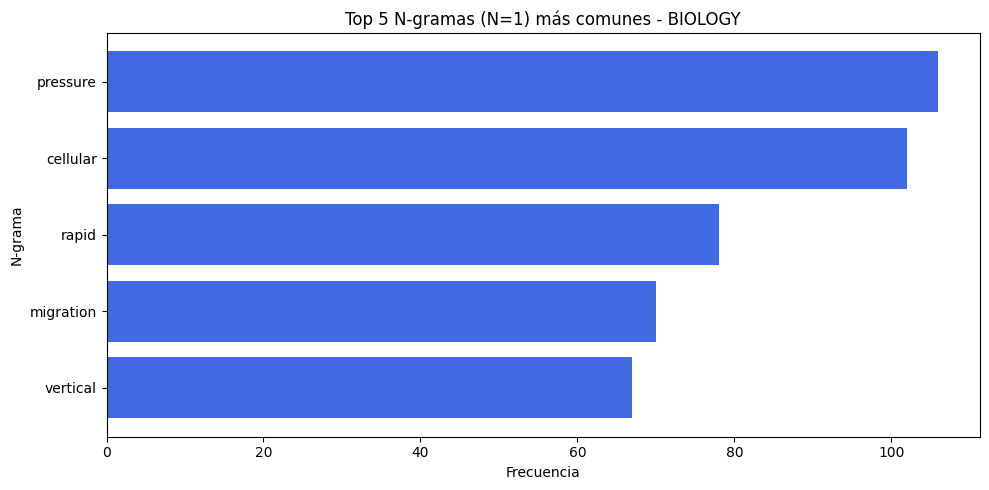

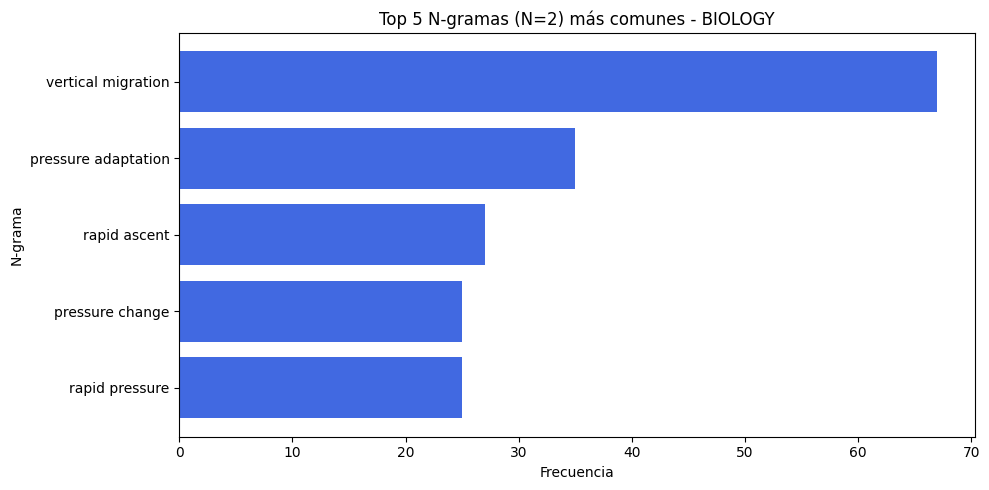

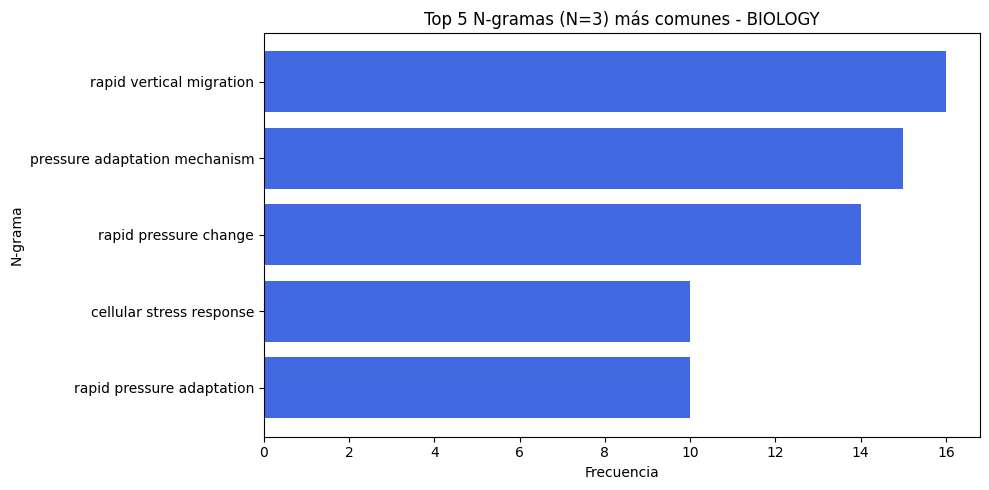

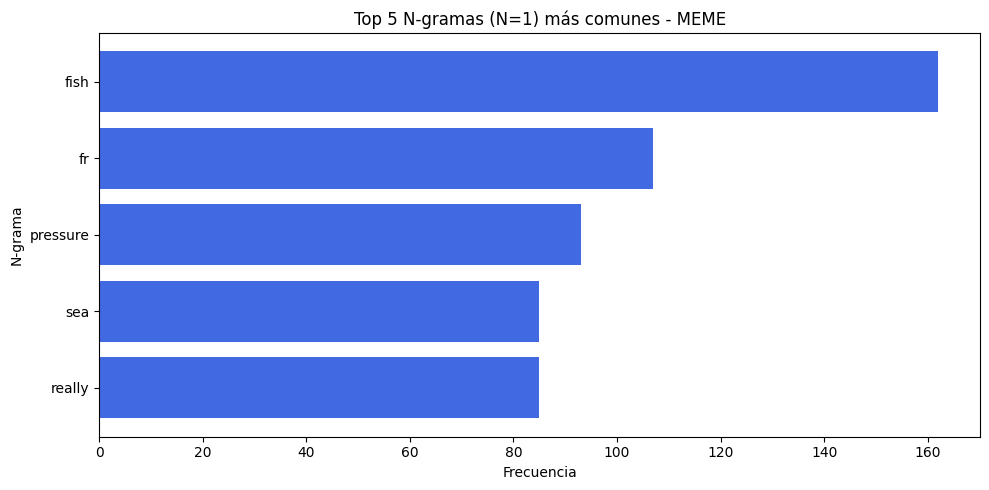

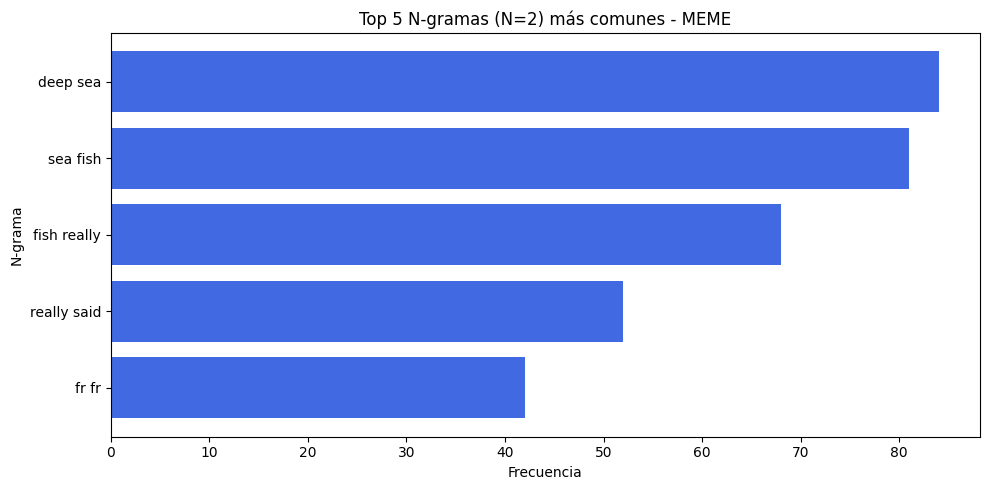

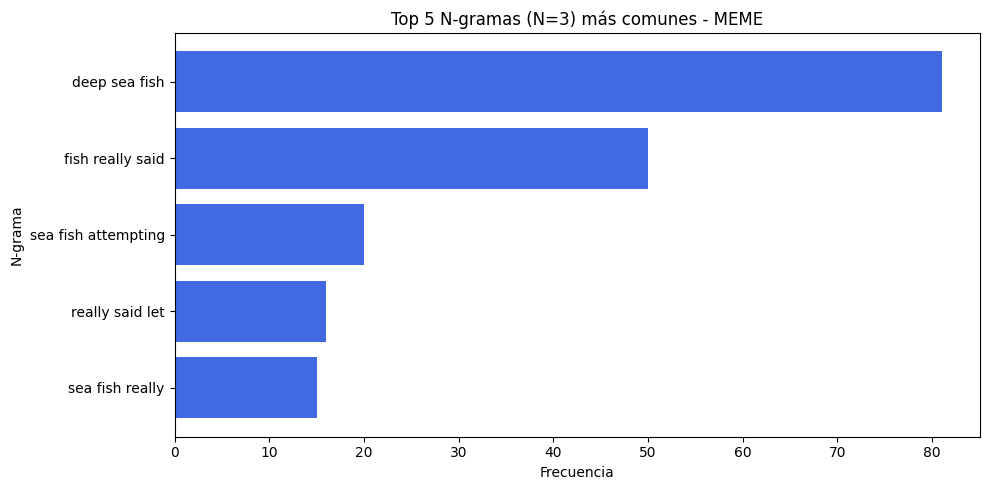

In [13]:
def plot_ngrams_bar(freq_dict, n, category):
    data = pd.Series(freq_dict)
    plt.figure(figsize=(10, 5))
    plt.barh(data.index, data.values, color='royalblue')
    plt.xlabel('Frecuencia')
    plt.ylabel('N-grama')
    plt.title(f"Top 5 N-gramas (N={n}) más comunes - {category}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

for n, freqs in ngrams_bio.items():
    plot_ngrams_bar(dict(list(freqs.items())[:5]), n, 'BIOLOGY')

for n, freqs in ngrams_meme.items():
    plot_ngrams_bar(dict(list(freqs.items())[:5]), n, 'MEME')


#nubes

In [14]:
def generate_wordcloud(freq_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

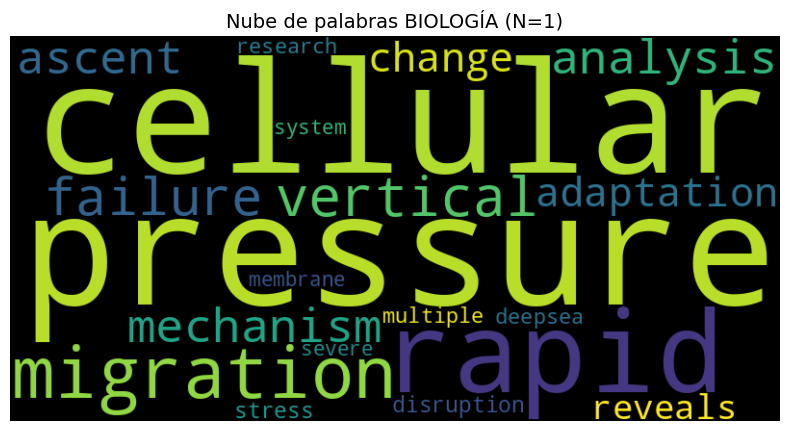

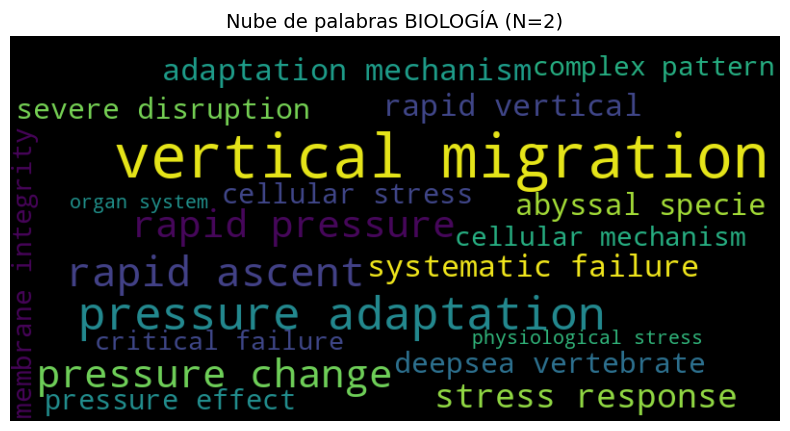

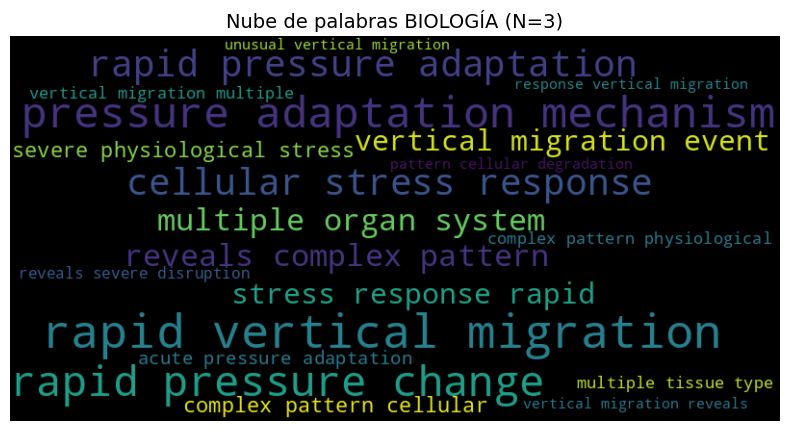

In [15]:
for n, freqs in ngrams_bio.items():
    generate_wordcloud(freqs, f'Nube de palabras BIOLOGÍA (N={n})')


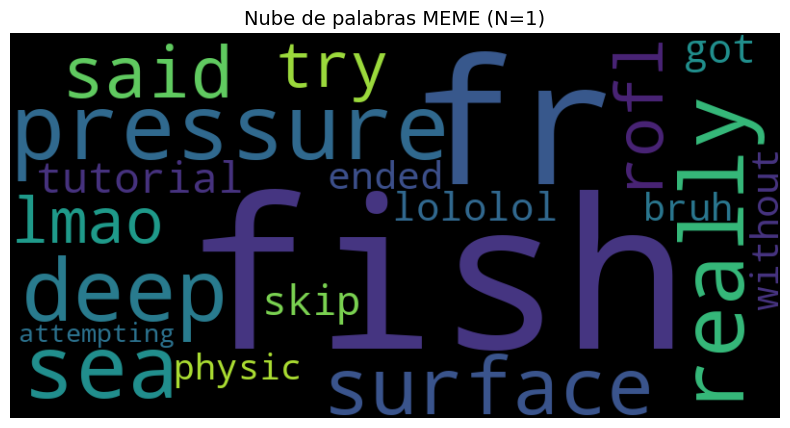

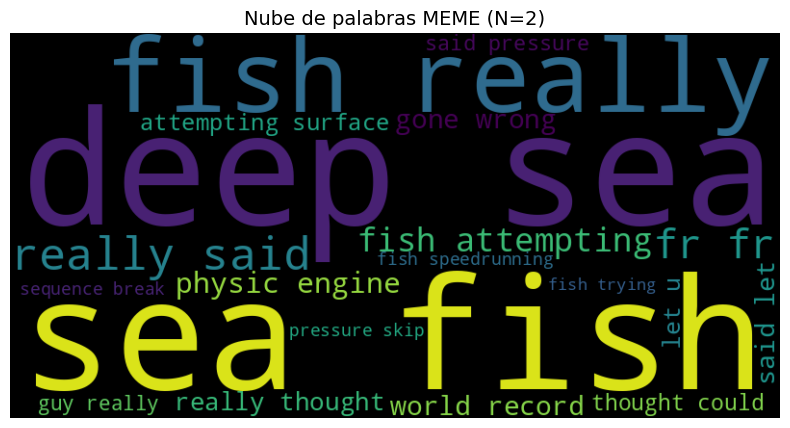

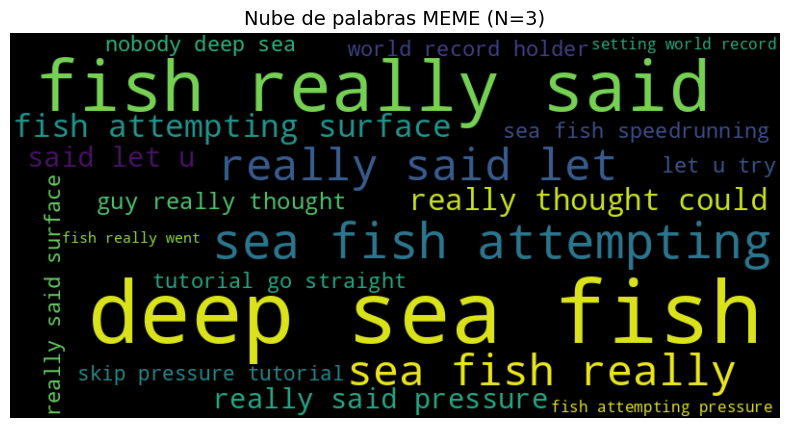

In [16]:
for n, freqs in ngrams_meme.items():
    generate_wordcloud(freqs, f'Nube de palabras MEME (N={n})')

#tsne

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tdidf_vectorizer=TfidfVectorizer(ngram_range=(1,1))
vectorized_tweets = tdidf_vectorizer.fit_transform(df['clean_tweet'])
vectorized_tweets

<462x794 sparse matrix of type '<class 'numpy.float64'>'
	with 5264 stored elements in Compressed Sparse Row format>

In [18]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,init='random')
tsne_result = model.fit_transform(vectorized_tweets)
tsne_result

array([[-1.17277136e+01, -2.59977779e+01],
       [-2.13128161e+00,  3.54479523e+01],
       [-1.43690710e+01, -2.37775364e+01],
       [ 1.35465164e+01,  2.64960747e+01],
       [-6.85674334e+00, -2.55544586e+01],
       [ 2.53472500e+01, -2.94954567e+01],
       [ 8.67582607e+00, -4.55081635e+01],
       [-6.75135803e+00,  3.57093582e+01],
       [-8.30097580e+00, -2.25379295e+01],
       [-5.20524979e+00,  4.38854485e+01],
       [-8.97786236e+00, -3.86469345e+01],
       [-9.59212875e+00,  4.39331741e+01],
       [-8.38784885e+00, -2.14203854e+01],
       [ 4.52412224e+00,  2.13767891e+01],
       [-1.49355831e+01, -2.43951702e+01],
       [-1.00384893e+01,  3.84148674e+01],
       [-1.25740871e+01, -2.06705990e+01],
       [ 3.63610625e+00,  3.99340057e+01],
       [ 2.31044922e+01, -2.97904911e+01],
       [ 1.46712341e+01,  2.21031609e+01],
       [-9.13877296e+00, -3.18629990e+01],
       [-1.82504349e+01,  3.67600288e+01],
       [-7.08887577e+00, -2.36741333e+01],
       [-1.

In [19]:
df['tsne_1']= tsne_result[:,0]
df['tsne_2']= tsne_result[:,1]

In [22]:
import plotly.express as px

fig = px.scatter(df, x='tsne_1', y='tsne_2',
                 color='category_label',
                 hover_data={'clean_tweet': True, 'category_label': True},
                 title="Mapa t-SNE de Tweets",
                 color_discrete_map={'BIOLOGY': 'blue', 'MEME': 'red'})

fig.update_layout(
    template="plotly_dark",
    plot_bgcolor="black",
    paper_bgcolor="black",
    font=dict(color="white")
)

fig.show()
